#**Import necessary libraries**

In [1]:
#Importing Data manipulation and plotting modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
import os
import warnings

In [2]:
#Importing libraries for Data pre-processing
from sklearn.preprocessing import StandardScaler as ss

In [3]:
#Importing model for Dimentionality Reduction
from sklearn.decomposition import PCA

In [4]:
#Importing libraries for performance measures
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve

In [5]:
#Importing libraries For data splitting
from sklearn.model_selection import train_test_split

In [6]:
#Importing libraries for Model pipelining
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [7]:
#Importing libraries for model parameter search and hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

In [8]:
#Importing Miscelaneous libraries
import time
import os
from scipy.stats import uniform

# Loading dataset

In [9]:
warnings.filterwarnings("ignore")

In [10]:
#Display all rows
pd.set_option('display.max_columns', 100)

In [11]:
os.chdir("../data_files/") 
data = pd.read_csv("winequalityN.csv")

## Get to know data and deleting rows having null values

In [12]:
data.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [14]:
data.shape

(6497, 13)

In [15]:
data.isnull().any()

type                    False
fixed acidity            True
volatile acidity         True
citric acid              True
residual sugar           True
chlorides                True
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                       True
sulphates                True
alcohol                 False
quality                 False
dtype: bool

In [16]:
data.dropna(axis=0,inplace=True)

In [17]:
data.isnull().any()

type                    False
fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

In [18]:
data.shape

(6463, 13)

# Exploring Dataset

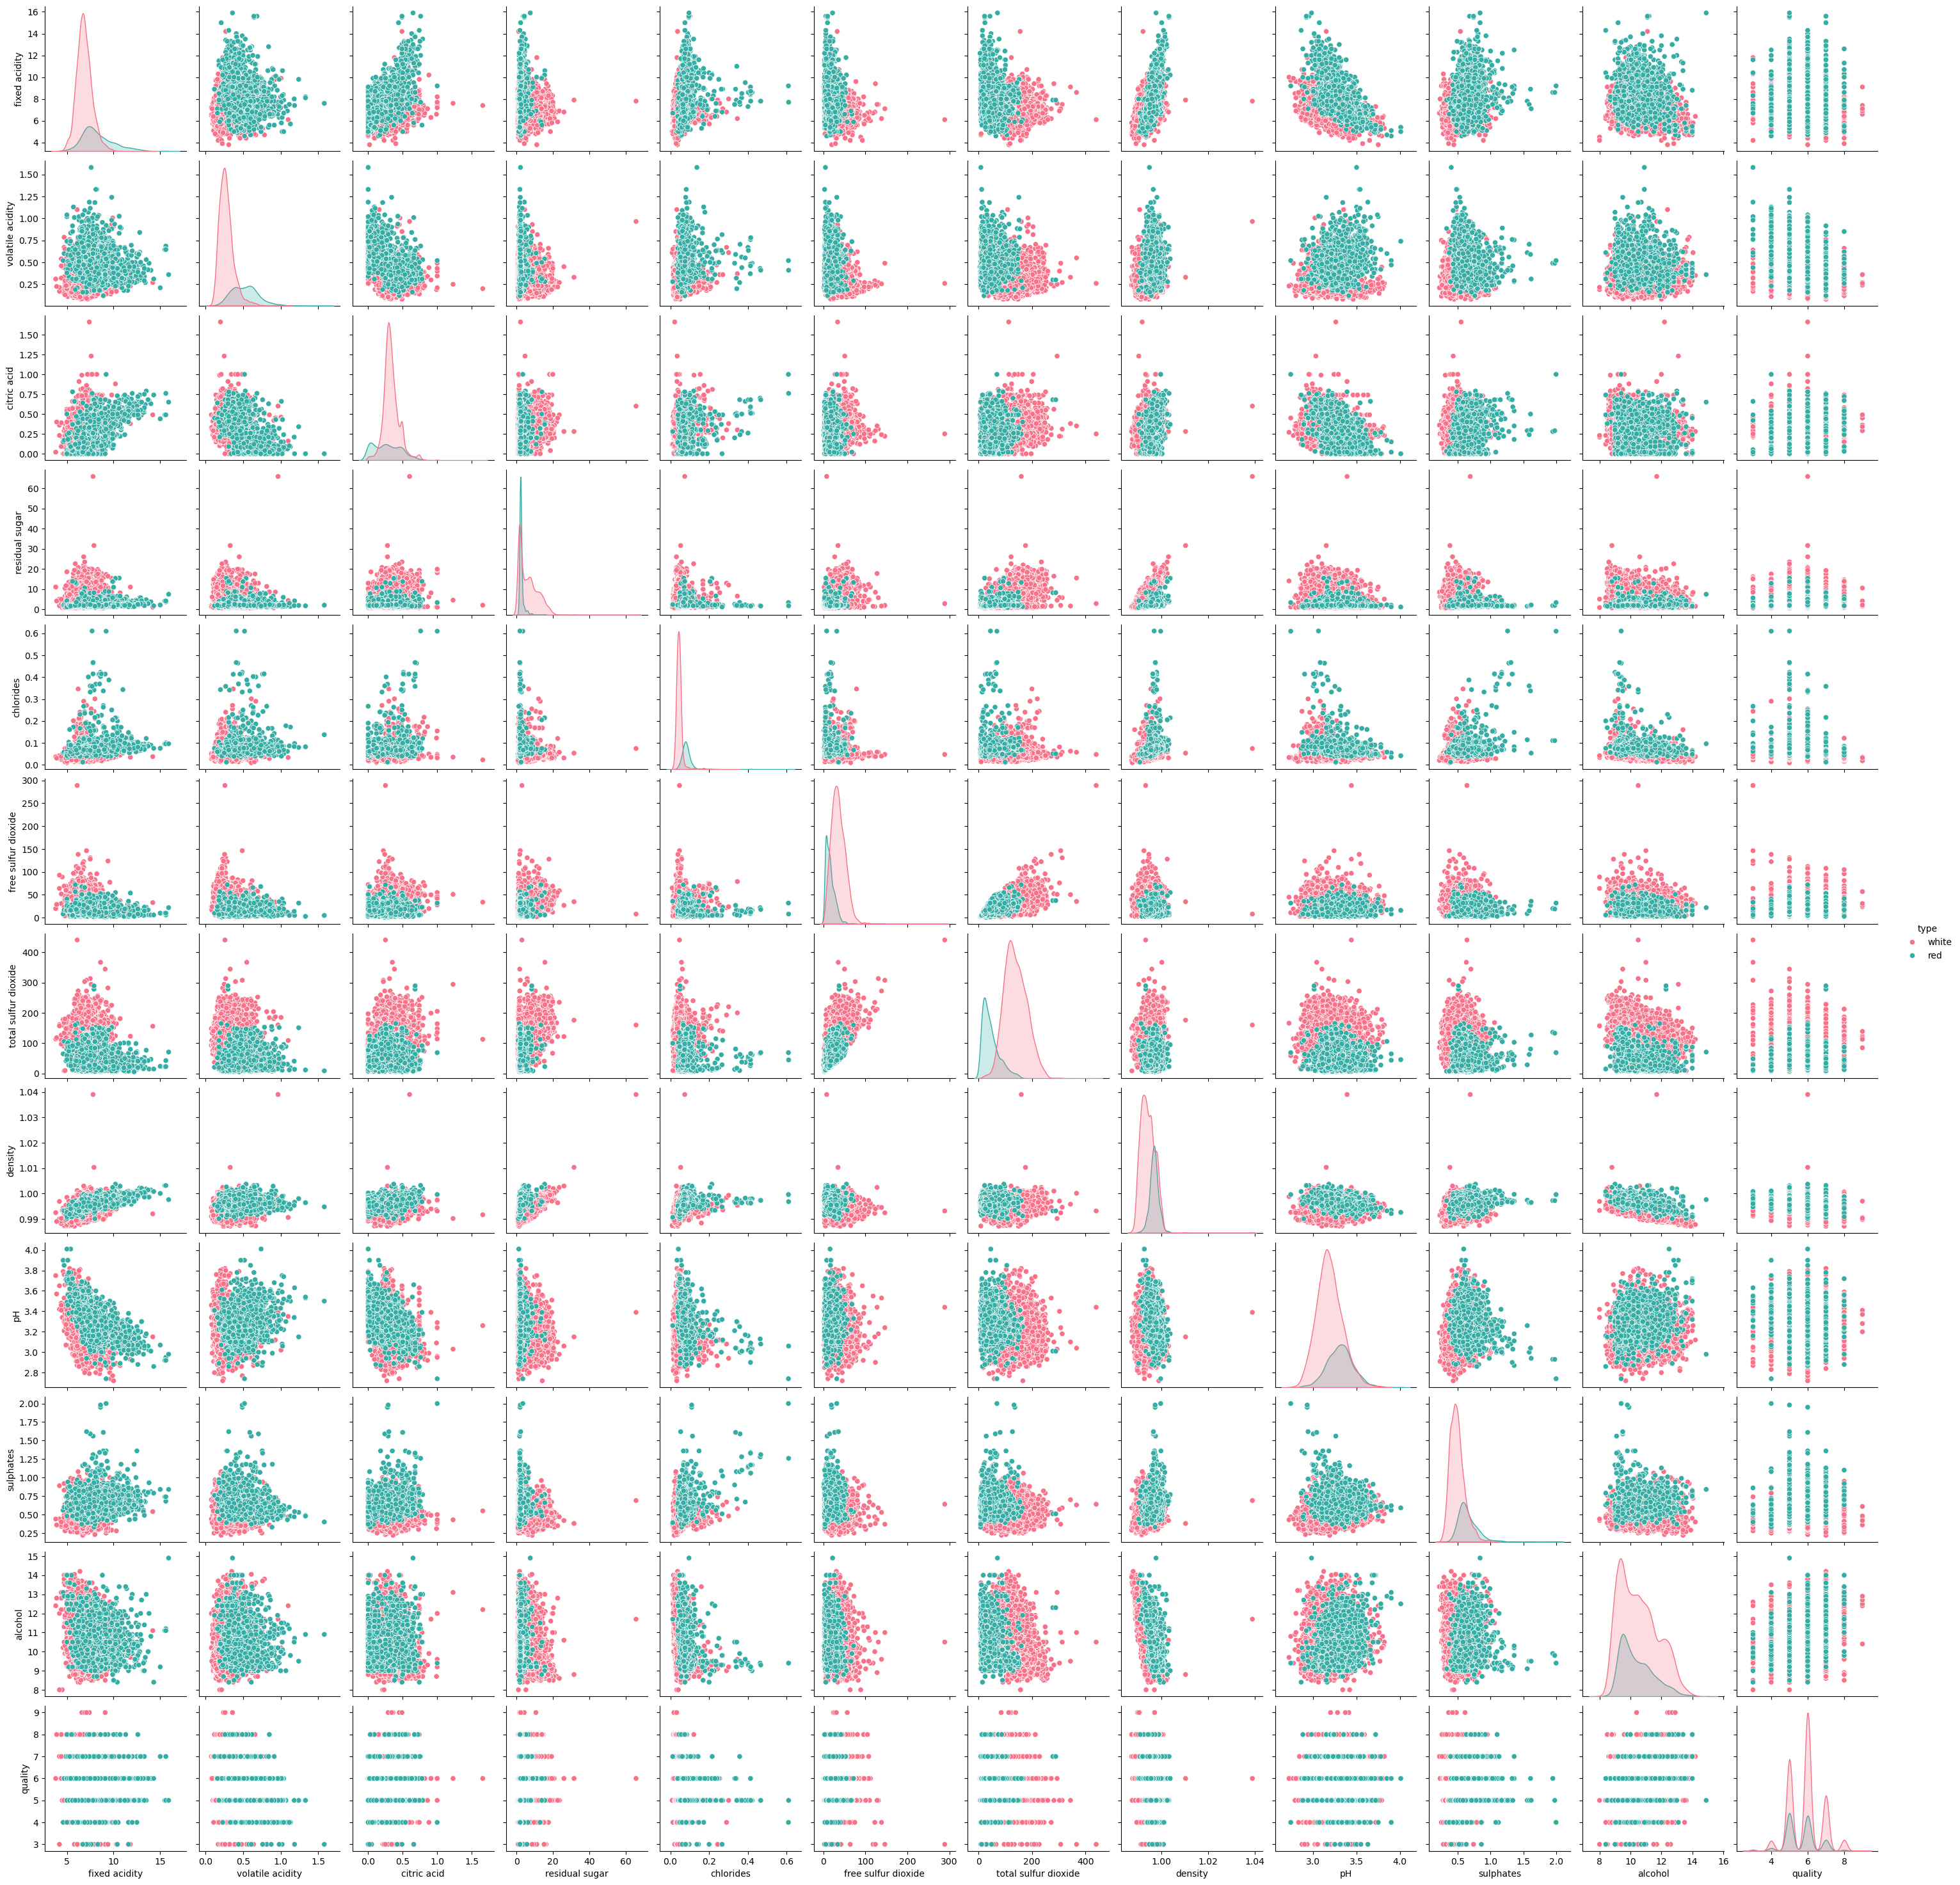

In [19]:
g = sns.pairplot(data,palette="husl",diag_kind="kde",hue='type')

### As we can see the figure shows many co-dependencies between features. Some observations -
### 1. Negative correlation between - i)Fixed acidity & pH, ii)density & alcohol. 
### 2. No correlation - i)alcohol & pH, ii)alcohol &  fixed acidity, iii)alcohol & volatile acidity 
### 3. Positive correlation - i)density and fixed acidity, ii)density & residual sugar, iii)Citric acid & fixed acidity:initially no correlation; but gng forward positive correlation.
###

In [20]:
data_numeric = data.iloc[:,1:]
data_numeric.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

<Axes: >

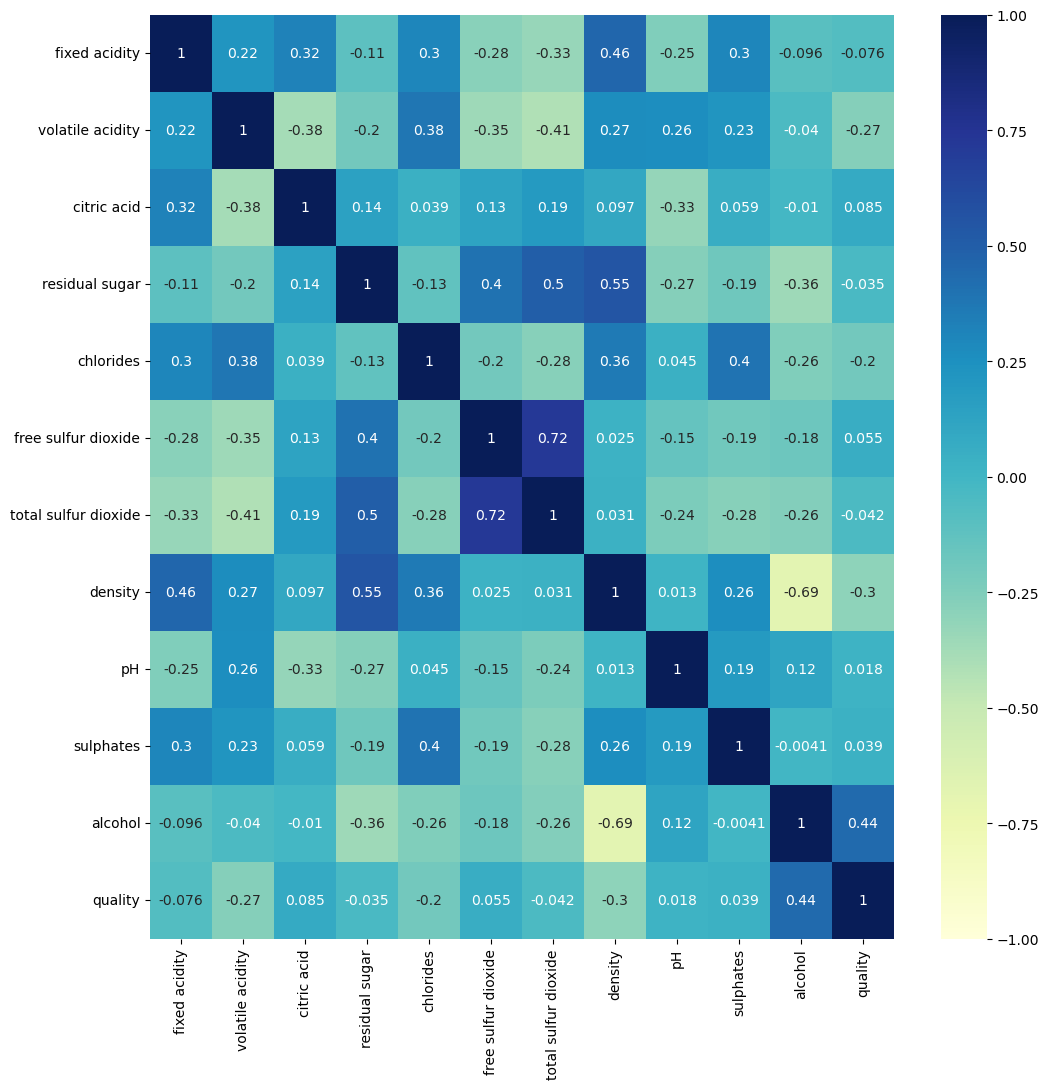

In [21]:
plt.figure(figsize=(12, 12))
sns.heatmap(data_numeric.corr(),annot=True,vmin=-1,cmap='YlGnBu')

### **Heatmap gives us more insights. Different shades of blue depict different levels of co-relationships between features.**
### **Positive values show linear or direct co-relationships between features. Higher the values stronger the co-relationships.**
### **They will be dark blue.**
### **On the other hand, negative values show an inverse co-relationship i.e as value of one feature increases the other one decreases.**
### **As the shade of blue decreases so does the co-relationship between the respective features.**
### **As you can see, the positive values show direct co-relationships between features.** 
### **The higher the values, the stronger these relationships are — they’ll be more bluish.**
### **That means, if one feature increases, the other one also tends to increase, and vice-versa.**
### **The squares that have negative values show an inverse co-relationship.**
### **The more negative these values get, the more inversely proportional they are, and they’ll be more blue.**
### **This means that if the value of one feature is higher, the value of the other one gets lower.**
### **Finally, values close to zero indicate almost no co-dependency between those sets of features.**

Text(0, 0.5, 'Quality')

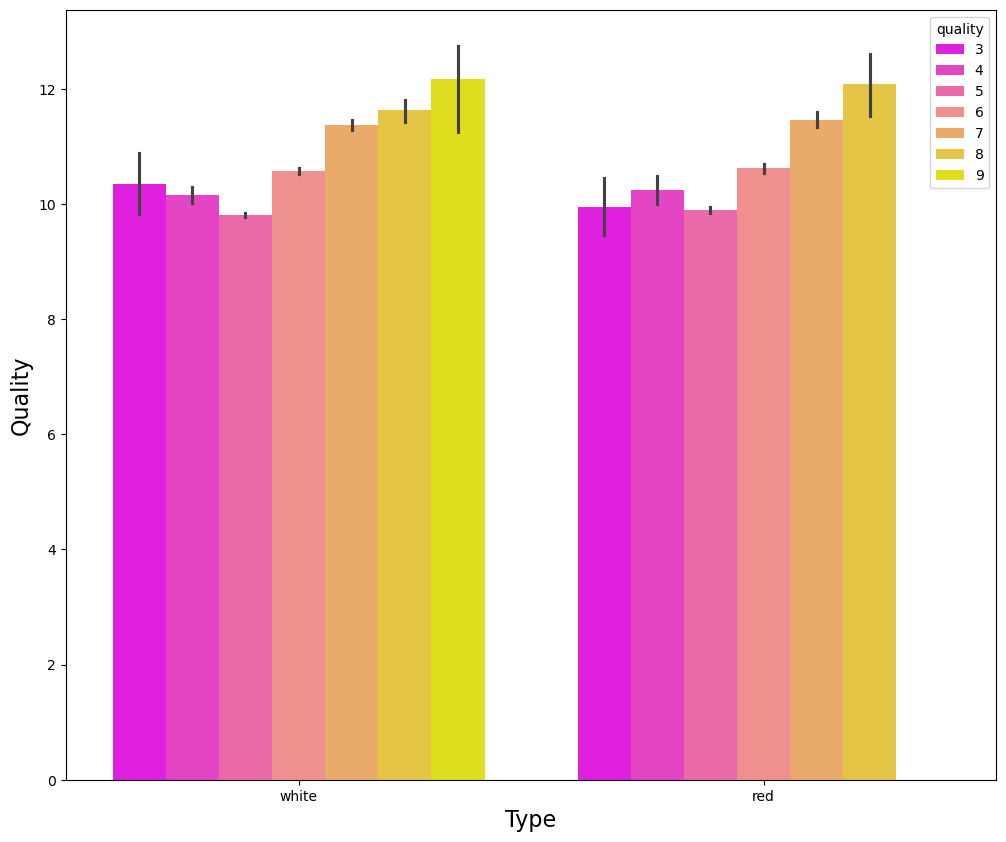

In [22]:
plt.figure(figsize=(12,10))
sns.barplot(x=data.type, y=data.alcohol,data=data, hue=data.quality,palette='spring')
plt.xlabel('Type',fontsize=16)
plt.ylabel('Quality',fontsize=16)

### **Wine types are separated and each component measure is compared. We can observe that alcohol quantity is slightly more in white wine.**

In [23]:
#Assuming wines with quality greater than 6 are best

wine_data = data.shape[0]
print("Total number of wine data: "+str(wine_data))
high_quality = data.loc[(data.quality)> 6]
print("Best quality wine entries: "+str(high_quality.shape[0]))
good_quality = data.loc[(data.quality)<5]
print("Good quality wine entries: "+str(good_quality.shape[0]))
end_of_month_wine = data.loc[(data.quality) < 3]
print("Mediocre quality wine entries: "+str(good_quality.shape[0]))

Total number of wine data: 6463
Best quality wine entries: 1271
Good quality wine entries: 244
Mediocre quality wine entries: 244


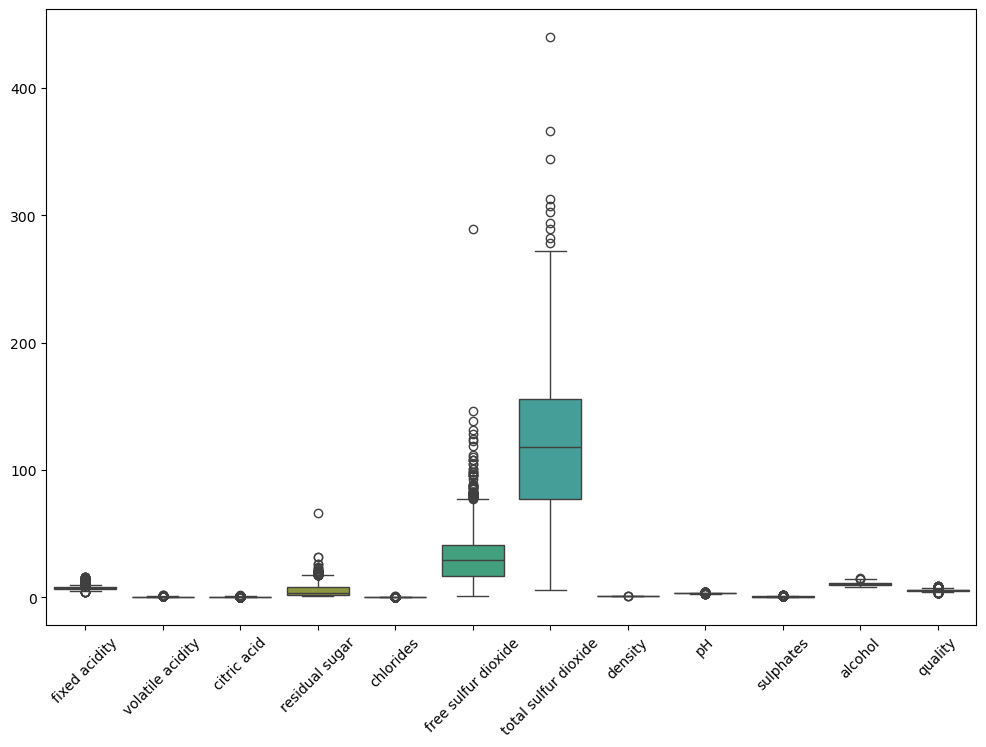

In [24]:
table = data.pivot_table('alcohol',index='quality',columns='type')
q = table.quantile(0.90)
df = table[table < q]
plt.figure(figsize=(12,8))
plt.xticks(rotation=45)
ax = sns.boxplot(data=data)

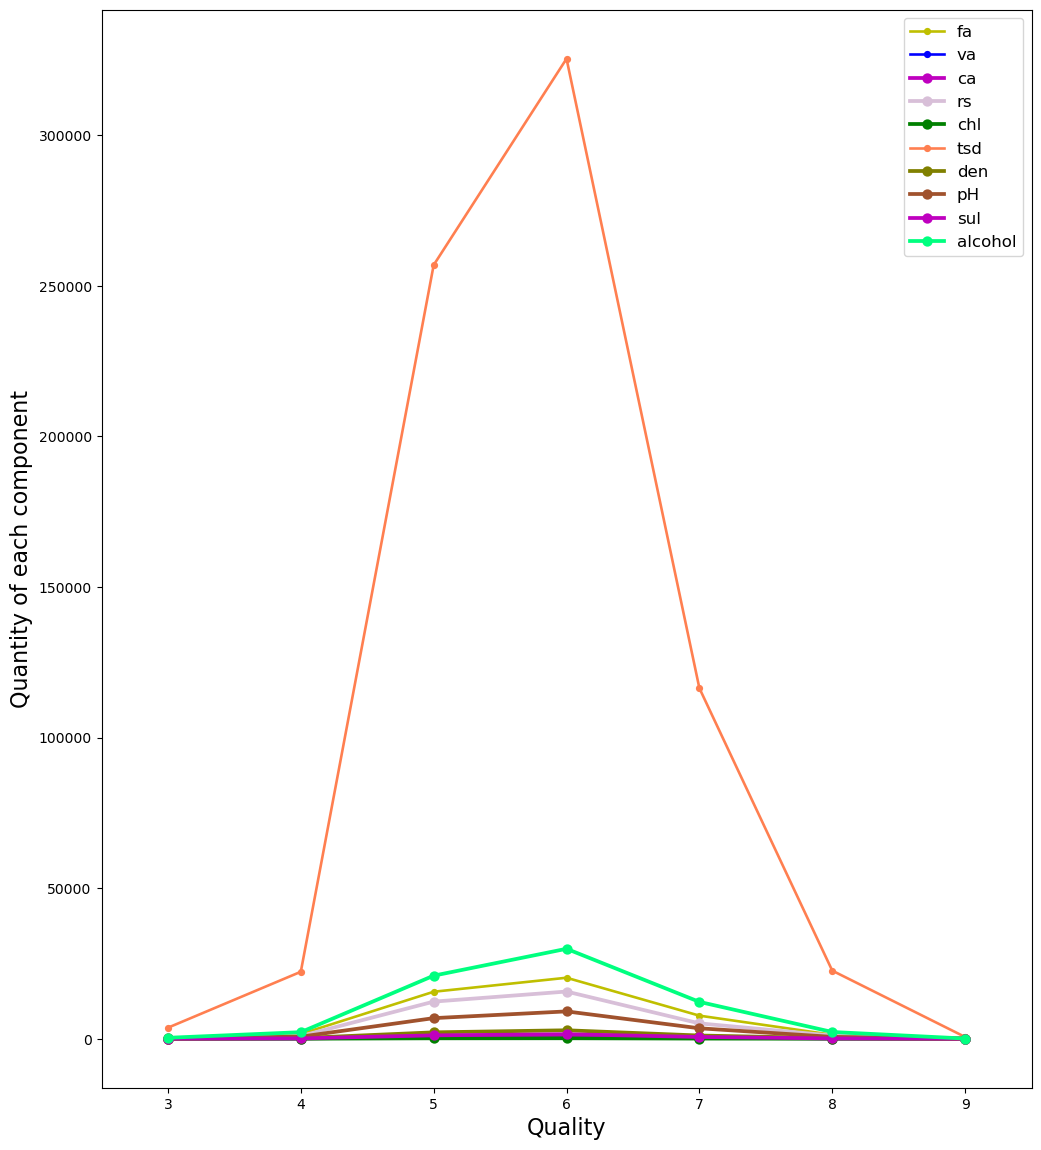

In [25]:
table_fa = data.pivot_table('fixed acidity',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_va = data.pivot_table('volatile acidity',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_ca = data.pivot_table('citric acid',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_rs = data.pivot_table('residual sugar',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_chl = data.pivot_table('chlorides',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_tsd = data.pivot_table('total sulfur dioxide',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_den = data.pivot_table('density',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_pH = data.pivot_table('pH',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_sul = data.pivot_table('sulphates',index='quality',columns='type',aggfunc='sum').sum(axis=1)
table_alcohol = data.pivot_table('alcohol',index='quality',columns='type',aggfunc='sum').sum(axis=1)
qual = table_alcohol.index.astype(int)
lbl = ['fa','va','ca','rs','chl','tsd','den','pH','sul','alcohol']

plt.figure(figsize=(12,14))
ax = sns.pointplot(x=qual, y=table_fa, color='y',scale=0.7)
ax = sns.pointplot(x=qual, y=table_va, color='b',scale=0.7)
ax = sns.pointplot(x=qual, y=table_ca, color='m', scale=1.0)
ax = sns.pointplot(x=qual, y=table_rs, color='thistle', scale=1.0)
ax = sns.pointplot(x=qual, y=table_chl, color='g', scale=1.0)
ax = sns.pointplot(x=qual, y=table_tsd, color='coral',scale=0.7)
ax = sns.pointplot(x=qual, y=table_den, color='olive', scale=1.0)
ax = sns.pointplot(x=qual, y=table_pH, color='sienna', scale=1.0)
ax = sns.pointplot(x=qual, y=table_sul, color='m', scale=1.0)
ax = sns.pointplot(x=qual, y=table_alcohol, color='springgreen', scale=1.0)

ax.set_xlabel(xlabel='Quality', fontsize=16)
ax.set_ylabel(ylabel='Quantity of each component', fontsize=16)
ax.legend(handles=ax.lines[::len(qual)+1],labels=lbl,fontsize=12)
plt.show();

### **We know that older the wine, better it tastes. Sulphur dioxide acts as a preservative and antioxidant which is widely used in winemaking.If it is carefully balanced out with pH then the quality of wine is preserved on storage. Hence we can observe that Total sulphur dioxide dominates all other wine components.It is followed by alcohol and density.**

Text(0, 0.5, 'Quantity')

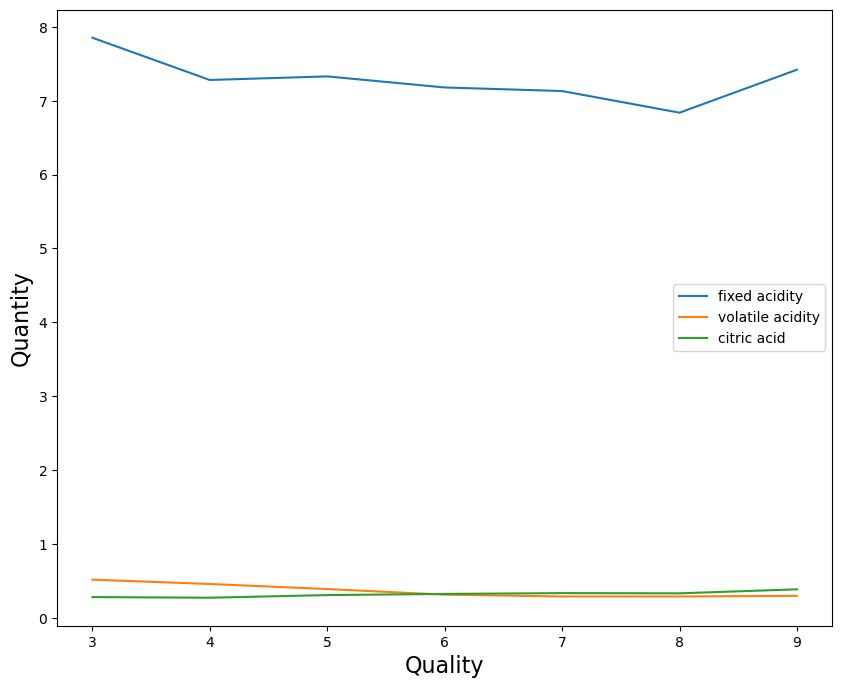

In [26]:
df = data.groupby(['quality'])
df_mean = df[['fixed acidity','volatile acidity','citric acid']].aggregate(np.mean)
df_mean.plot(figsize=(10,8))
plt.xlabel('Quality',fontsize=16)
plt.ylabel('Quantity',fontsize=16)

### **The fixed acidity content is more as compared to volatile acid and citric acid. Combination of these acids contribute to the taste of wine.**

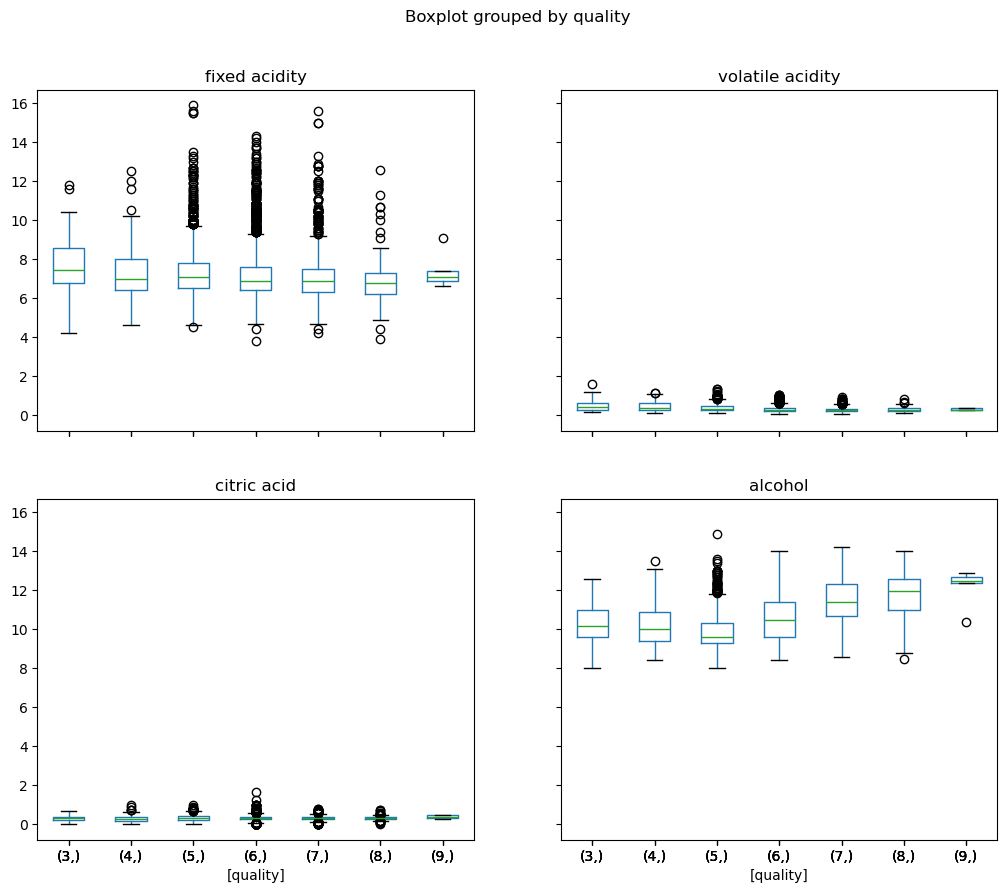

In [27]:
fig = plt.figure(figsize=(12, 10));
ax = fig.add_subplot(1,1,1)
bp = data.boxplot(grid=False,layout=(2,2),column=['fixed acidity','volatile acidity','citric acid','alcohol'], by=['quality'],ax=ax)


### **It can be observed that - higher the alcohol content better is the wine quality**

# **Split data as predictors and target**

In [28]:
#Last 13 columns as predictors
X = data.iloc[ :, 1:14]
X.head(2)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   

   free sulfur dioxide  total sulfur dioxide  density   pH  sulphates  \
0                 45.0                 170.0    1.001  3.0       0.45   
1                 14.0                 132.0    0.994  3.3       0.49   

   alcohol  quality  
0      8.8        6  
1      9.5        6

In [29]:
#First column as target
y = data.iloc[ : , 0]
y.head()

0    white
1    white
2    white
3    white
4    white
Name: type, dtype: object

In [30]:
y = y.map({'white':1, 'red' : 0})
y.dtype

dtype('int64')

In [31]:
#Divide dataset into Training data and validation data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.35,
                                                    shuffle = True
                                                    )

# **Hyperparameter tuning and Pipelining using XGBoost**

In [32]:
xgb_list = [('ss',ss()),         #Scaling parameters
            ('pca',PCA()),       #Instantiate PCA
            ('xgb',XGBClassifier(silent = False,  #Instantiate XGB classifier with 2 cpu threads 
                                  n_jobs=2))]

In [33]:
#Instantiate Pipeline object
xgb_pipeline = Pipeline(xgb_list, verbose=False)


In [34]:
#A parameter grid for grid search
parameter_gs = {'xgb__learning_rate':  [0.04, 0.07],
              'xgb__n_estimators':   [150,  200],
              'xgb__max_depth':      [3,5],
              'pca__n_components' : [7,12]
              #'verbose' : False
              }

## **Grid Search**

In [35]:
grid_search = GridSearchCV(xgb_pipeline,            # XGB pipeline object
                   parameter_gs,         # 2*2*2*2 parameter grid
                   n_jobs = 2,         # No. of parallel cpu threads
                   cv =2 ,             # No. of folds
                   verbose =0,      
                   scoring = ['accuracy', 'roc_auc'],  # Performance metrics
                   refit = 'roc_auc'   # Refitting final model those which maximise auc
                   )

In [36]:
#Fitting data to Pipeline
grid_search.fit(X_train, y_train)   

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ss', StandardScaler()), ('pca', PCA()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gamma=None,
                                                      grow...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=2,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=2,
             param_grid={'pca__n_components': [7, 12],
                         'xgb__learning_rate': [0.04, 0.07],
                         'xgb__max_depth': [3, 5],
                         'xgb__n_estimators': [150, 200]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [37]:
f"Best score: {grid_search.best_score_} "

'Best score: 0.99627657780091 '

In [38]:
f"Best parameter set {grid_search.best_params_}"

"Best parameter set {'pca__n_components': 12, 'xgb__learning_rate': 0.07, 'xgb__max_depth': 3, 'xgb__n_estimators': 150}"

([0, 1, 2, 3],
 [Text(0, 0, 'pca__n_components'),
  Text(1, 0, 'xgb__learning_rate'),
  Text(2, 0, 'xgb__max_depth'),
  Text(3, 0, 'xgb__n_estimators')])

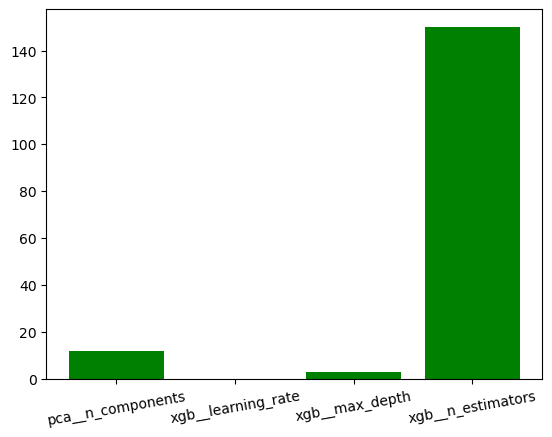

In [39]:
plt.bar(grid_search.best_params_.keys(), grid_search.best_params_.values(), color='g')
plt.xticks(rotation=10)

In [40]:
y_pred = grid_search.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 1, 1])

In [41]:
accuracy = accuracy_score(y_test, y_pred)

In [42]:
f"Accuracy: {accuracy * 100.0}"

'Accuracy: 99.42554131683606'

## **Random Search**

In [43]:
#A parameter set for random search
parameter_rs = {'xgb__learning_rate':  uniform(0, 1),
              'xgb__n_estimators':   range(60,120),
              'xgb__max_depth':      range(4,7),
              'pca__n_components' : range(5,7)}

In [44]:
random_search = RandomizedSearchCV(xgb_pipeline,
                        param_distributions=parameter_rs,
                        scoring= ['roc_auc', 'accuracy'],
                        n_iter=15,          # Max combination of
                        verbose = 3,
                        refit = 'roc_auc',
                        n_jobs = 2,          # No. of parallel cpu threads
                        cv = 2               # No of folds.
                        )

In [45]:
#Fitting data to Pipeline
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()
(end - start)/60

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2] END pca__n_components=6, xgb__learning_rate=0.13819394639949067, xgb__max_depth=6, xgb__n_estimators=75; accuracy: (test=0.983) roc_auc: (test=0.990) total time=   0.0s
[CV 2/2] END pca__n_components=6, xgb__learning_rate=0.13819394639949067, xgb__max_depth=6, xgb__n_estimators=75; accuracy: (test=0.991) roc_auc: (test=0.996) total time=   0.0s
[CV 1/2] END pca__n_components=6, xgb__learning_rate=0.9784694904899743, xgb__max_depth=4, xgb__n_estimators=115; accuracy: (test=0.982) roc_auc: (test=0.988) total time=   0.0s
[CV 2/2] END pca__n_components=6, xgb__learning_rate=0.9784694904899743, xgb__max_depth=4, xgb__n_estimators=115; accuracy: (test=0.990) roc_auc: (test=0.994) total time=   0.0s
[CV 1/2] END pca__n_components=5, xgb__learning_rate=0.9957037588523188, xgb__max_depth=5, xgb__n_estimators=111; accuracy: (test=0.983) roc_auc: (test=0.990) total time=   0.0s
[CV 1/2] END pca__n_components=6, xgb__learning_r

0.004666368166605632

In [46]:
f"Best score: {random_search.best_score_} "

'Best score: 0.992884173317141 '

In [47]:
f"Best parameter set: {random_search.best_params_} "

"Best parameter set: {'pca__n_components': 6, 'xgb__learning_rate': np.float64(0.13819394639949067), 'xgb__max_depth': 6, 'xgb__n_estimators': 75} "

([0, 1, 2, 3],
 [Text(0, 0, 'pca__n_components'),
  Text(1, 0, 'xgb__learning_rate'),
  Text(2, 0, 'xgb__max_depth'),
  Text(3, 0, 'xgb__n_estimators')])

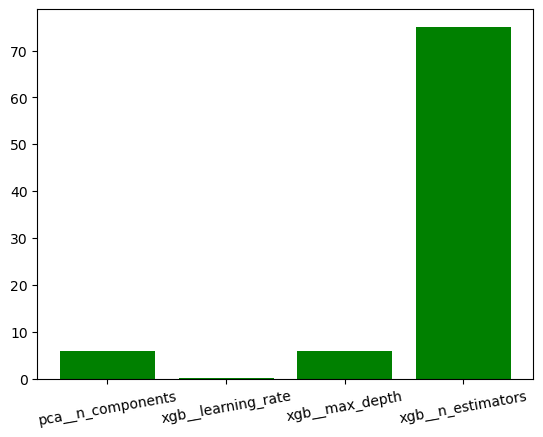

In [48]:
plt.bar(random_search.best_params_.keys(), random_search.best_params_.values(), color='g')
plt.xticks(rotation=10)

In [49]:
y_pred = random_search.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 1, 1])

In [50]:
accuracy = accuracy_score(y_test, y_pred)
f"Accuracy: {accuracy * 100.0}"

'Accuracy: 98.93946089262042'

## **Bayesian Optimization**

In [51]:
parameter_bo = {
           'learning_rate':  (0, 1),            
           'n_estimators':   (60,120),         
           'max_depth':      (4,7),            
           'n_components' :  (5,7)
            }

In [52]:

def xg_eval(learning_rate,n_estimators, max_depth,n_components):
    #Make Pipeling for BO
    pipe_xg1 = make_pipeline (ss(),
                              PCA(n_components=int(round(n_components))),
                              XGBClassifier(
                                           silent = False,
                                           n_jobs=2,
                                           learning_rate=learning_rate,
                                           max_depth=int(round(max_depth)),
                                           n_estimators=int(round(n_estimators))
                                           )
                             )
    #Fitting into pipeline 
    cv_result = cross_val_score(estimator = pipe_xg1,
                                X= X_train,
                                y = y_train,
                                cv = 2,
                                n_jobs = 2,
                                scoring = 'f1'
                                ).mean()             # taking mean of all results

    return cv_result       #Returning final mean of all results of cross val score

In [53]:
bayesian_opt = BayesianOptimization(
                             xg_eval,     
                             parameter_bo   
                             )

In [54]:
start = time.time()

In [55]:
bayesian_opt.maximize(init_points=5,
               n_iter=15      
               )

|   iter    |  target   | learni... | n_esti... | max_depth | n_comp... |
-------------------------------------------------------------------------
| 1         | 0.8562091 | 0.0022756 | 93.697049 | 6.9169902 | 5.7532199 |
| 2         | 0.9909400 | 0.6222882 | 67.822240 | 4.1121228 | 5.9609730 |
| 3         | 0.9912538 | 0.7278400 | 112.83438 | 6.9110378 | 6.8946390 |
| 4         | 0.9914130 | 0.2009743 | 68.022466 | 6.2455487 | 6.8797005 |
| 5         | 0.9917337 | 0.6164266 | 82.175600 | 4.0818961 | 5.6425571 |
| 6         | 0.8562091 | 0.0       | 120.0     | 4.0       | 5.0       |
| 7         | 0.9917337 | 0.5070802 | 75.106109 | 4.6657229 | 6.0628838 |
| 8         | 0.9887169 | 1.0       | 60.0      | 7.0       | 5.0       |
| 9         | 0.9907790 | 1.0       | 106.85610 | 4.0       | 7.0       |
| 10        | 0.8562091 | 0.0       | 108.32525 | 7.0       | 5.0       |
| 11        | 0.9918890 | 0.4381559 | 70.033452 | 5.0425804 | 6.3211256 |
| 12        | 0.9902974 | 0.2181222 | 

In [56]:
f"Best parameter set: {bayesian_opt.max} "

"Best parameter set: {'target': np.float64(0.9918890368228696), 'params': {'learning_rate': np.float64(0.43815599182026227), 'n_estimators': np.float64(70.03345277297926), 'max_depth': np.float64(5.0425804746255425), 'n_components': np.float64(6.3211256433675755)}} "

In [57]:
bayesian_opt.max.values()

dict_values([np.float64(0.9918890368228696), {'learning_rate': np.float64(0.43815599182026227), 'n_estimators': np.float64(70.03345277297926), 'max_depth': np.float64(5.0425804746255425), 'n_components': np.float64(6.3211256433675755)}])

In [58]:
for features in bayesian_opt.max.values(): 
    print(features)

0.9918890368228696
{'learning_rate': np.float64(0.43815599182026227), 'n_estimators': np.float64(70.03345277297926), 'max_depth': np.float64(5.0425804746255425), 'n_components': np.float64(6.3211256433675755)}


In [59]:
features

{'learning_rate': np.float64(0.43815599182026227),
 'n_estimators': np.float64(70.03345277297926),
 'max_depth': np.float64(5.0425804746255425),
 'n_components': np.float64(6.3211256433675755)}

([0, 1, 2, 3],
 [Text(0, 0, 'learning_rate'),
  Text(1, 0, 'n_estimators'),
  Text(2, 0, 'max_depth'),
  Text(3, 0, 'n_components')])

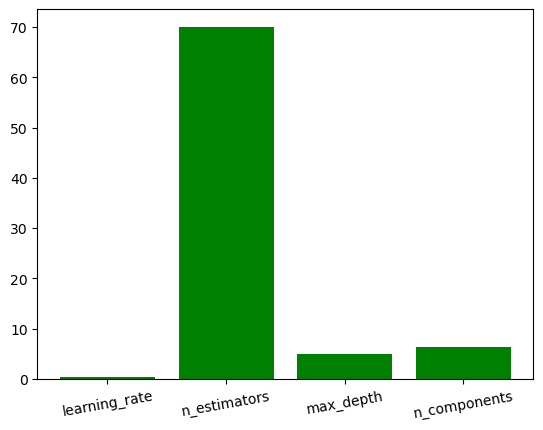

In [60]:
plt.bar(features.keys(), features.values(), color='g')
plt.xticks(rotation=10)

# **Fitting parameters into our model and Feature Importance**

In [61]:
#Model with parameters of grid search
model_gs = XGBClassifier(
                    learning_rate = grid_search.best_params_['xgb__learning_rate'],
                    max_depth = grid_search.best_params_['xgb__max_depth'],
                    n_estimators=grid_search.best_params_['xgb__n_estimators']
                    )

#Model with parameters of random search
model_rs = XGBClassifier(
                    learning_rate = random_search.best_params_['xgb__learning_rate'],
                    max_depth = random_search.best_params_['xgb__max_depth'],
                    n_estimators=random_search.best_params_['xgb__n_estimators']
                    )

#Model with parameters of bayesian optimization
model_bo = XGBClassifier(
                    learning_rate = int(features['learning_rate']),
                    max_depth = int(features['max_depth']),
                    n_estimators=int(features['n_estimators'])
                    )

In [62]:
start = time.time()
model_gs.fit(X_train, y_train)
model_rs.fit(X_train, y_train)
model_bo.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=70,
              n_jobs=None, num_parallel_tree=None, ...)

In [63]:
y_pred_gs = model_gs.predict(X_test)
y_pred_rs = model_rs.predict(X_test)
y_pred_bo = model_bo.predict(X_test)

In [64]:
accuracy_gs = accuracy_score(y_test, y_pred_gs)
accuracy_rs = accuracy_score(y_test, y_pred_rs)
accuracy_bo = accuracy_score(y_test, y_pred_gs)

In [65]:
print("Grid search Accuracy: "+str(accuracy_gs))
print("Grid search Accuracy: "+str(accuracy_rs))
print("Bayesian Optimization Accuracy: "+str(accuracy_bo))

Grid search Accuracy: 0.9951391957578436
Grid search Accuracy: 0.9955810870525851
Bayesian Optimization Accuracy: 0.9951391957578436


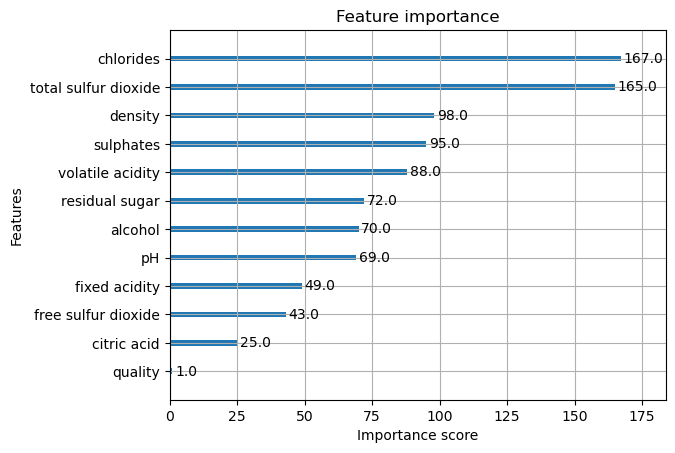

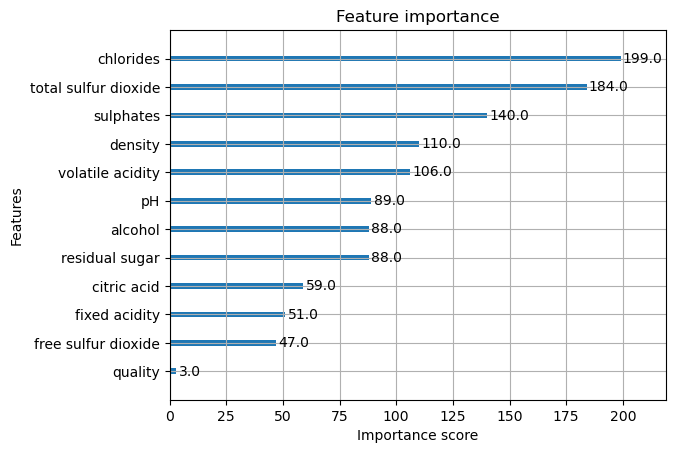

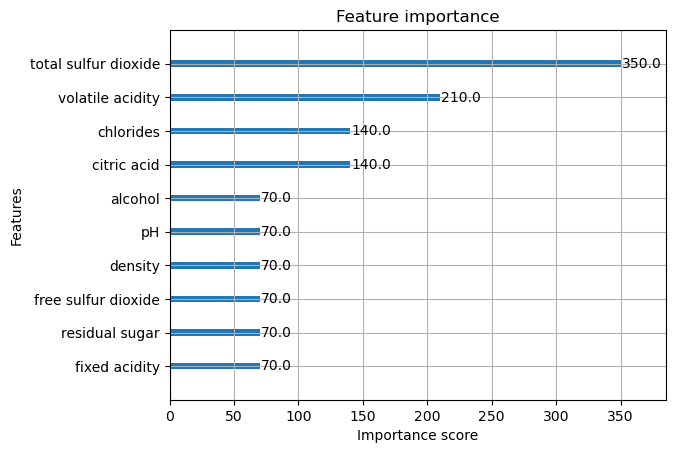

In [66]:
model_gs.feature_importances_
model_rs.feature_importances_
model_bo.feature_importances_
plot_importance(model_gs)
plot_importance(model_rs)
plot_importance(model_bo)
plt.show()